In [16]:
import math
def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    low_z, low_p = -10.0, 0 # normal_cdf(-10) is (very close to) 0
    hi_z, hi_p = 10.0, 1 # normal_cdf(10) is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2 # consider the midpoint
        mid_p = normal_cdf(mid_z) # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break
    return mid_z
    """The function repeatedly bisects intervals until it narrows in on a Z that’s close enough to
        the desired probability."""

### Example: Flipping a Coin
Imagine we have a coin and we want to test whether it’s fair. We’ll make the assumption
that the coin has some probability p of landing heads, and so our null hypothesis is that the
coin is fair — that is, that  `p=0.5`. We’ll test this against the alternative hypothesis `p!=0.5`.

```cmd
In the theory of probability and statistics, a Bernoulli trial is a random experiment with exactly two possible outcomes, "success" and "failure", in which the probability of success is the same every time the experiment is conducted.
```

In particular, our test will involve flipping the coin some number n times and counting the
number of heads X. Each coin flip is a Bernoulli trial, which means that X is a
Binomial(n,p) random variable, which (as we saw in Chapter 6) we can approximate using
the normal distribution:

In [17]:
def normal_approximation_to_binomial(n,p):
    '''finds mu and sigma corresponding to binomial(n,p)'''
    mu = p*n
    sigma = math.sqrt(p*(1-p)*n)
    return mu,sigma

Whenever a random variable follows a normal distribution, we can use normal_cdf to
figure out the probability that its realized value lies within (or outside) a particular
interval:

In [18]:
# the normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = normal_cdf
# it's above the threshold if it's not below the threshold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)
# it's between if it's less than hi, but not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)
# it's outside if it's not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

We can also do the reverse — find either the nontail region or the (symmetric) interval
around the mean that accounts for a certain level of likelihood. For example, if we want to
find an interval centered at the mean and containing 60% probability, then we find the
cutoffs where the upper and lower tails each contain 20% of the probability (leaving 60%):

In [19]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)
def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)
def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds
    that contain the specified probability"""
    tail_probability = (1 - probability) / 2
    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound

In particular, let’s say that we choose to flip the coin `n=1000 ` times. If our
hypothesis of fairness is true, X should be distributed approximately normally with mean
50 and standard deviation 15.8:


In [20]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)

In [21]:
mu_0 

500.0

In [22]:
sigma_0

15.811388300841896

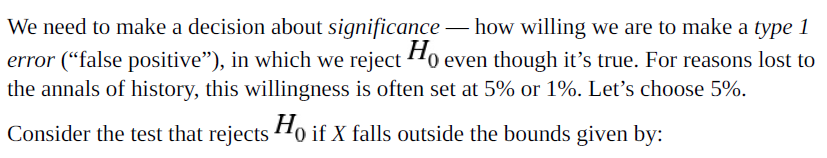


In [23]:
normal_two_sided_bounds(0.95, mu_0, sigma_0) # (469, 531)

(469.01026640487555, 530.9897335951244)

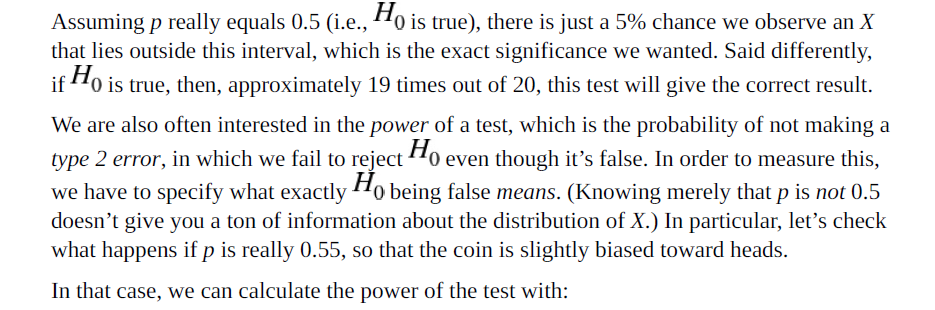

In [24]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
# a type 2 error means we fail to reject the null hypothesis
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability # 0.887

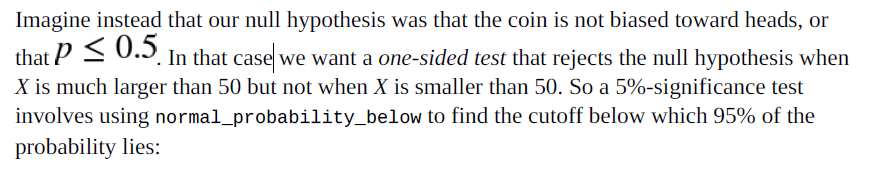

In [25]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
# is 526 (< 531, since we need more probability in the upper tail)
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability # 0.936

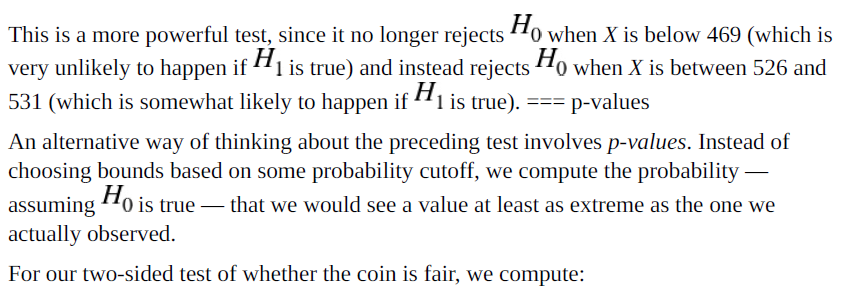

In [27]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than the mean, the tail is what's greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # if x is less than the mean, the tail is what's less than x
        return 2 * normal_probability_below(x, mu, sigma)

In [28]:
# If we were to see 530 heads, we would compute:
two_sided_p_value(529.5, mu_0, sigma_0) # 0.062

0.06207721579598835

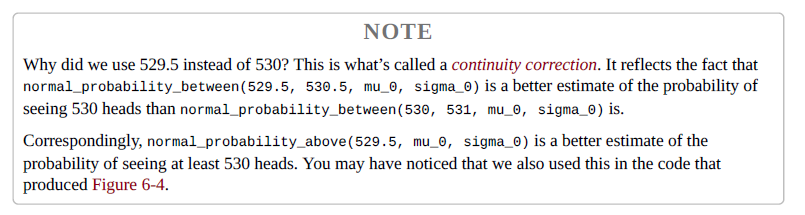

In [33]:
import random
# One way to convince ourselves that this is a sensible estimate is with a simulation:
extreme_value_count = 0
for _ in range(100000):
    num_heads = sum(1 if random.random() < 0.5 else 0 # count # of heads 
                    for _ in range(1000)) # in 1000 flips
    if num_heads >= 530 or num_heads <= 470: # and count how often
        extreme_value_count += 1 # the # is 'extreme'
print(extreme_value_count / 100000) # 0.062

0.06143


In [34]:
#Since the p-value is greater than our 5% significance, we don’t reject the null. If we
#instead saw 532 heads, the p-value would be:
two_sided_p_value(531.5, mu_0, sigma_0) 

0.046345287837786575

which is smaller than the 5% significance, which means we would reject the null. It’s the
exact same test as before. It’s just a different way of approaching the statistics.

In [35]:
#similarly we would have
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [36]:
#For our one-sided test, if we saw 525 heads we would compute:
upper_p_value(524.5, mu_0, sigma_0) # 0.061
#which means we wouldn’t reject the null. If we saw 527 heads, the computation would be:
upper_p_value(526.5, mu_0, sigma_0) # 0.047
#and we would reject the null.

0.04686839508859242

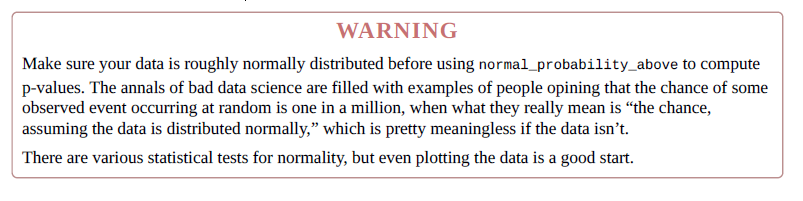

### Confidence Intervals
We’ve been testing hypotheses about the value of the heads probability p, which is a
parameter of the unknown “heads” distribution. When this is the case, a third approach is
to construct a confidence interval around the observed value of the parameter.

For example, we can estimate the probability of the unfair coin by looking at the average
value of the Bernoulli variables corresponding to each flip — 1 if heads, 0 if tails. If we
observe 525 heads out of 1,000 flips, then we estimate p equals 0.525.

How confident can we be about this estimate? Well, if we knew the exact value of p, the
central limit theorem (recall “The Central Limit Theorem”) tells us that the average of
those Bernoulli variables should be approximately normal, with mean p and standard
deviation:

In [37]:
# math.sqrt(p * (1 - p) / 1000)
# Here we don’t know p, so instead we use our estimate:
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000) 

In [38]:
sigma

0.015791611697353755

This is not entirely justified, but people seem to do it anyway. Using the normal
approximation, we conclude that we are “95% confident” that the following interval
contains the true parameter p:

In [39]:
normal_two_sided_bounds(.95 , mu,sigma)

(0.4940490278129096, 0.5559509721870904)

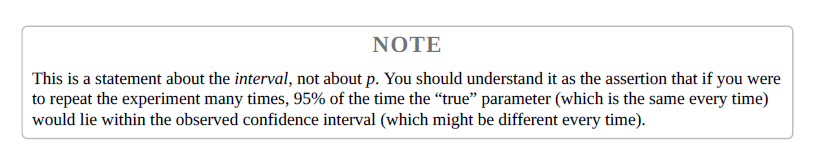

In particular, we do not conclude that the coin is unfair, since 0.5 falls within our
confidence interval.
If instead we’d seen 540 heads, then we’d have:
```python
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000) # 0.0158
normal_two_sided_bounds(0.95, mu, sigma) # [0.5091, 0.5709]
```
Here, “fair coin” doesn’t lie in the confidence interval. (The “fair coin” hypothesis doesn’t
pass a test that you’d expect it to pass 95% of the time if it were true.)

### P-hacking
A procedure that erroneously rejects the null hypothesis only 5% of the time will — by
definition — 5% of the time erroneously reject the null hypothesis:

In [41]:
def run_experiment():
    """flip a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]
def reject_fairness(experiment):
    """using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment for experiment in experiments if reject_fairness(experiment)])
print(num_rejections)

46


What this means is that if you’re setting out to find “significant” results, you usually can.
Test enough hypotheses against your data set, and one of them will almost certainly appear
significant. Remove the right outliers, and you can probably get your p value below 0
.05.
(We did something vaguely similar in “Correlation”; did you notice?)
This is sometimes called P-hacking and is in some ways a consequence of the “inference
from p-values framework.” A good article criticizing this approach is “The Earth Is
Round.”

If you want to do good science, you should determine your hypotheses before looking at
the data, you should clean your data without the hypotheses in mind, and you should keep
in mind that p-values are not substitutes for common sense. (An alternative approach is
“Bayesian Inference”.)

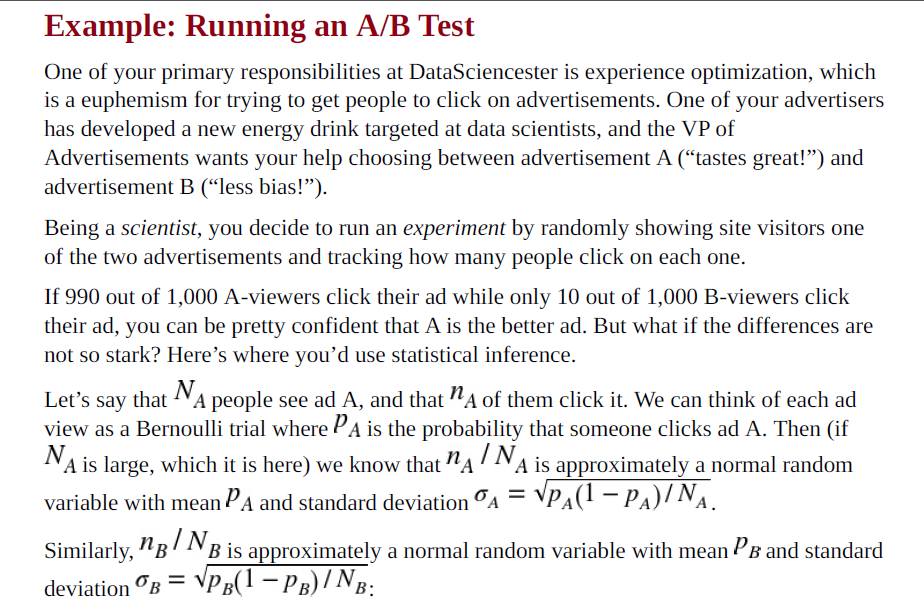

In [44]:
def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

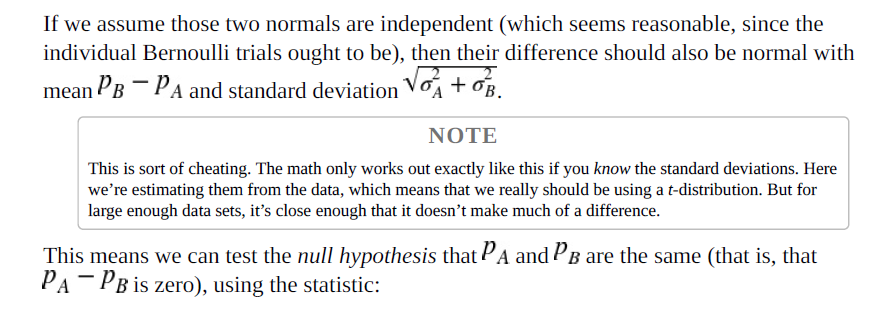

In [45]:
def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

which should approximately be a standard normal.
For example, if “tastes great” gets 200 clicks out of 1,000 views and “less bias” gets 180
clicks out of 1,000 views, the statistic equals:

In [48]:
z = a_b_test_statistic(1000,200,1000,180)

In [49]:
#The probability of seeing such a large difference if the means were actually equal would be:
two_sided_p_value(z)

0.254141976542236

In [50]:
# which is large enough that you can’t conclude there’s much of a difference. On the other
# hand, if “less bias” only got 150 clicks, we’d have:

z = a_b_test_statistic(1000,200,1000,150)

In [51]:
two_sided_p_value(z)

0.003189699706216853

which means there’s only a 0.003 probability you’d see such a large difference if the ads
were equally effective.

### Bayesian Inference
The procedures we’ve looked at have involved making probability statements about our
tests: “there’s only a 3% chance you’d observe such an extreme statistic if our null
hypothesis were true.”

An alternative approach to inference involves treating the unknown parameters themselves
as random variables. The analyst (that’s you) starts with a prior distribution for the
parameters and then uses the observed data and Bayes’s Theorem to get an updated
posterior distribution for the parameters. Rather than making probability judgments about
the tests, you make probability judgments about the parameters themselves.

For example, when the unknown parameter is a probability (as in our coin-flipping
example), we often use a prior from the Beta distribution, which puts all its probability
between 0 and 1:

In [52]:
def B(alpha, beta):
    """a normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)
def beta_pdf(x, alpha, beta):
    if x < 0 or x > 1: # no weight outside of [0, 1]
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

Generally speaking, this distribution centers its weight at:
```python
alpha / (alpha + beta)
```
and the larger alpha and beta are, the “tighter” the distribution is.
For example, if alpha and beta are both 1, it’s just the uniform distribution (centered at
0.5, very dispersed). If alpha is much larger than beta, most of the weight is near 1. And
if alpha is much smaller than beta, most of the weight is near zero. Figure 7-1 shows
several different Beta distributions.

So let’s say we assume a prior distribution on p. Maybe we don’t want to take a stand on
whether the coin is fair, and we choose alpha and beta to both equal 1. Or maybe we have
a strong belief that it lands heads 55% of the time, and we choose alpha equals 55, beta
equals 45.

Then we flip our coin a bunch of times and see h heads and t tails. Bayes’s Theorem (and
some mathematics that’s too tedious for us to go through here) tells us that the posterior
distribution for p is again a Beta distribution but with parameters alpha + h and beta +
t.

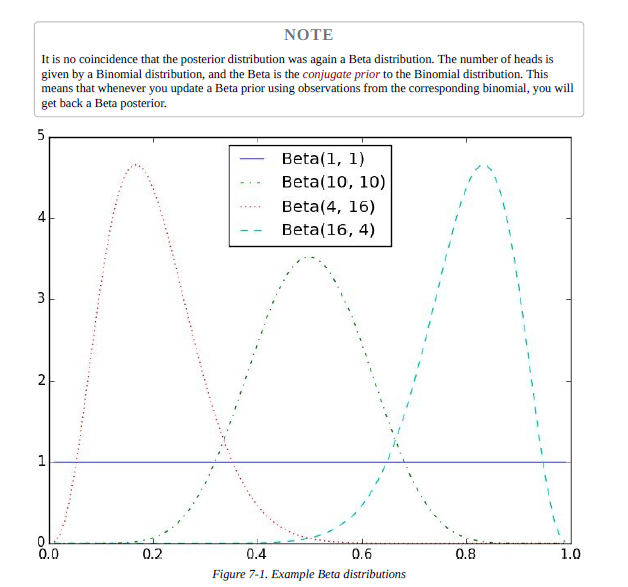

Let’s say you flip the coin 10 times and see only 3 heads.
If you started with the uniform prior (in some sense refusing to take a stand about the
coin’s fairness), your posterior distribution would be a Beta(4, 8), centered around 0.33.
Since you considered all probabilities equally likely, your best guess is something pretty
close to the observed probability.

If you started with a Beta(20, 20) (expressing the belief that the coin was roughly fair),
your posterior distribution would be a Beta(23, 27), centered around 0.46, indicating a
revised belief that maybe the coin is slightly biased toward tails.

And if you started with a Beta(30, 10) (expressing a belief that the coin was biased to flip
75% heads), your posterior distribution would be a Beta(33, 17), centered around 0.66. In
that case you’d still believe in a heads bias, but less strongly than you did initially. These
three different posteriors are plotted in Figure 7-2.

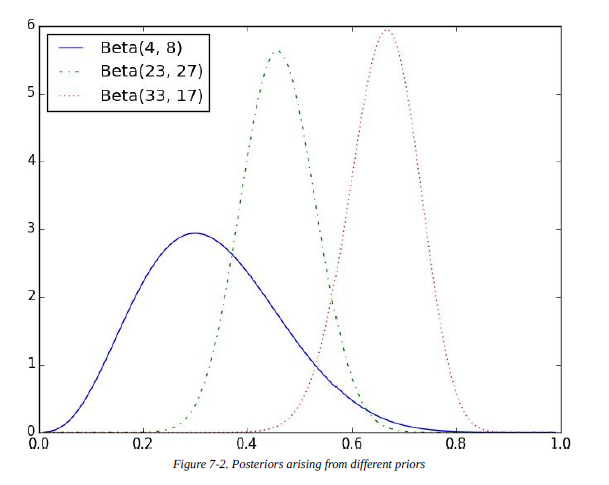

If you flipped the coin more and more times, the prior would matter less and less until
eventually you’d have (nearly) the same posterior distribution no matter which prior you
started with.

For example, no matter how biased you initially thought the coin was, it would be hard to
maintain that belief after seeing 1,000 heads out of 2,000 flips (unless you are a lunatic
who picks something like a Beta(1000000,1) prior).

What’s interesting is that this allows us to make probability statements about hypotheses:
“Based on the prior and the observed data, there is only a 5% likelihood the coin’s heads
probability is between 49% and 51%.” This is philosophically very different from a
statement like “if the coin were fair we would expect to observe data so extreme only 5%
of the time.”

Using Bayesian inference to test hypotheses is considered somewhat controversial — in
part because its mathematics can get somewhat complicated, and in part because of the
subjective nature of choosing a prior. We won’t use it any further in this book, but it’s
good to know about.